In [1]:
library(fpp3)
options(repr.plot.width=10, repr.plot.height=5)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── fpp3 0.4.0 ──

✔ tibble      3.0.6      ✔ tsibble     1.0.0 
✔ dplyr       1.0.4      ✔ tsibbledata 0.2.0 
✔ tidyr       1.1.2      ✔ feasts      0.1.7 
✔ lubridate   1.7.10     ✔ fable       0.3.0 
✔ ggplot2     3.3.3      

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks base::intersect()
✖ tsibble::interval()  masks lubridate::interval()
✖ dplyr::lag()         masks stats::lag()
✖ tsibble::setdiff()   masks base::setdiff()
✖ tsibble::union()     masks base::union()



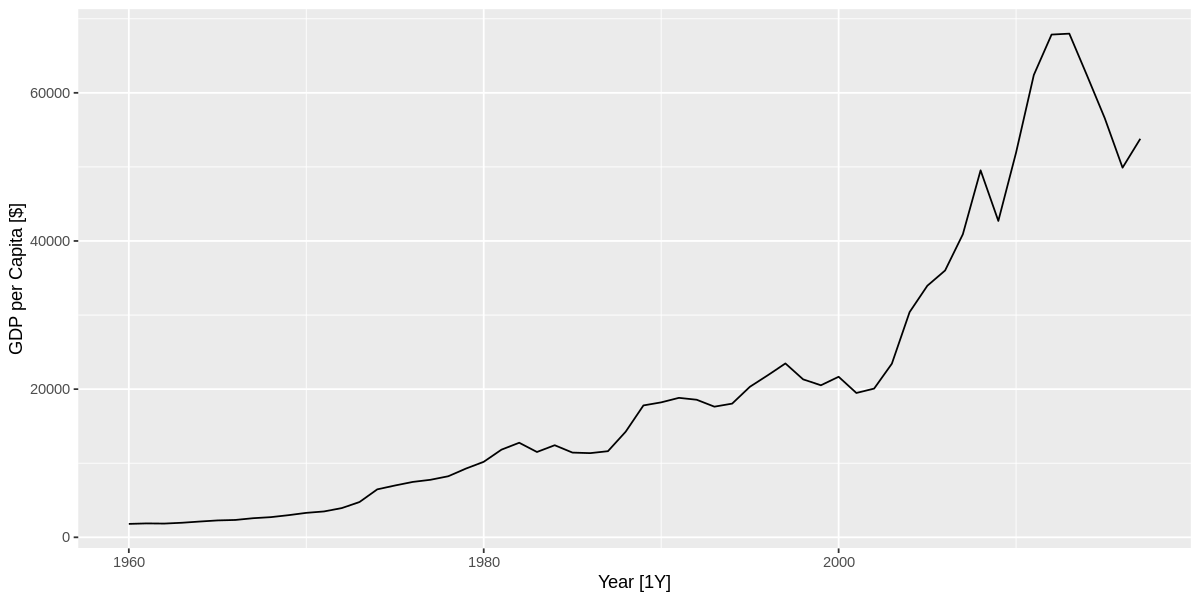

In [2]:
global_economy %>%
    filter(Country == 'Australia') %>%
    autoplot(GDP / Population) +
    labs(y = "GDP per Capita [$]")

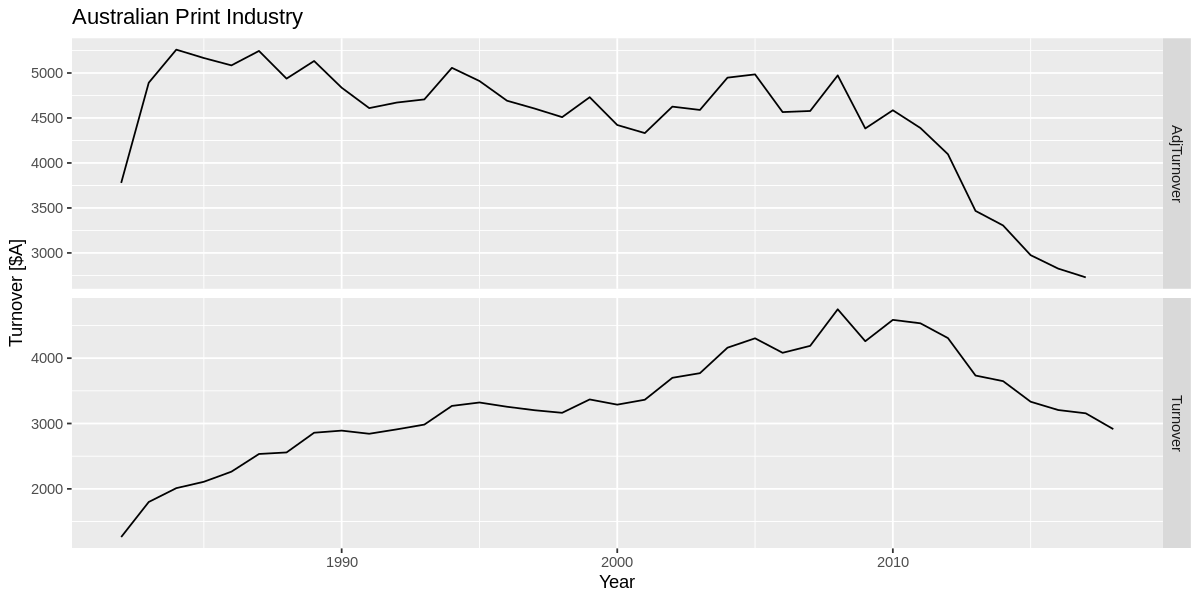

In [3]:
print_retail <- aus_retail %>%
    filter(Industry == "Newspaper and book retailing") %>%
    group_by(Industry) %>%
    index_by(Year = year(Month)) %>%
    summarise(Turnover = sum(Turnover))

aus_economy <- global_economy %>%
    filter(Code == "AUS")

print_retail %>%
    left_join(aus_economy, by = "Year") %>%
    mutate(AdjTurnover = Turnover / CPI * 100) %>%
    pivot_longer(c(Turnover, AdjTurnover), values_to = "Turnover") %>%
    ggplot(aes(Year, Turnover)) +
    geom_line() +
    facet_grid(name ~ ., scales = "free_y") +
    labs(y = "Turnover [$A]", title = "Australian Print Industry")

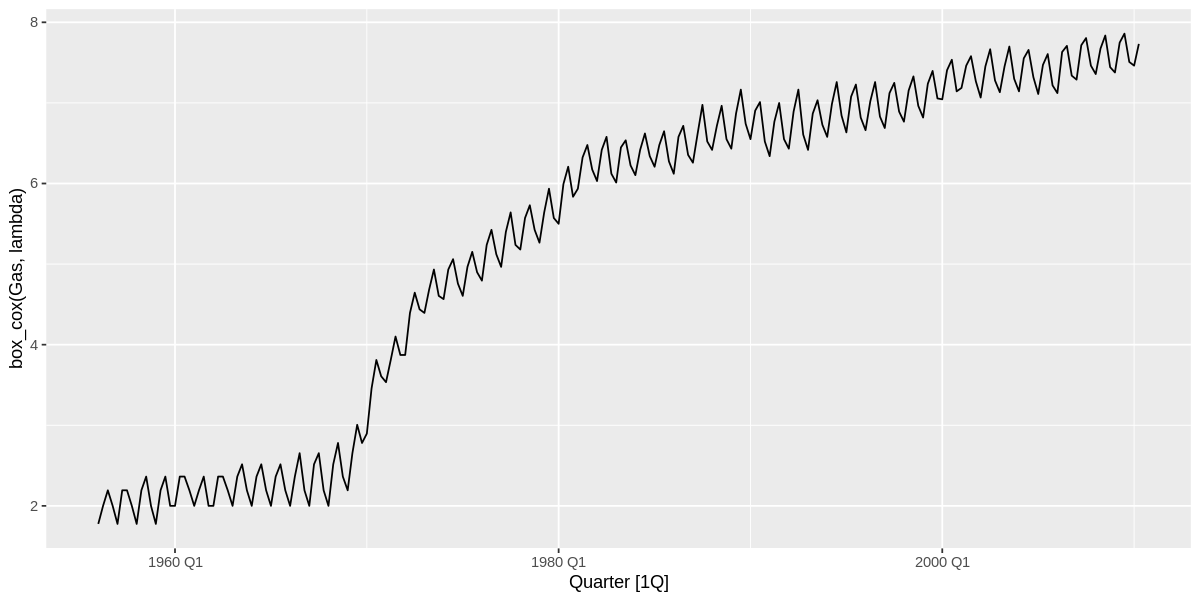

In [4]:
lambda <- aus_production %>%
    features(Gas, features = guerrero) %>%
    pull(lambda_guerrero)

aus_production %>%
    autoplot(box_cox(Gas, lambda))

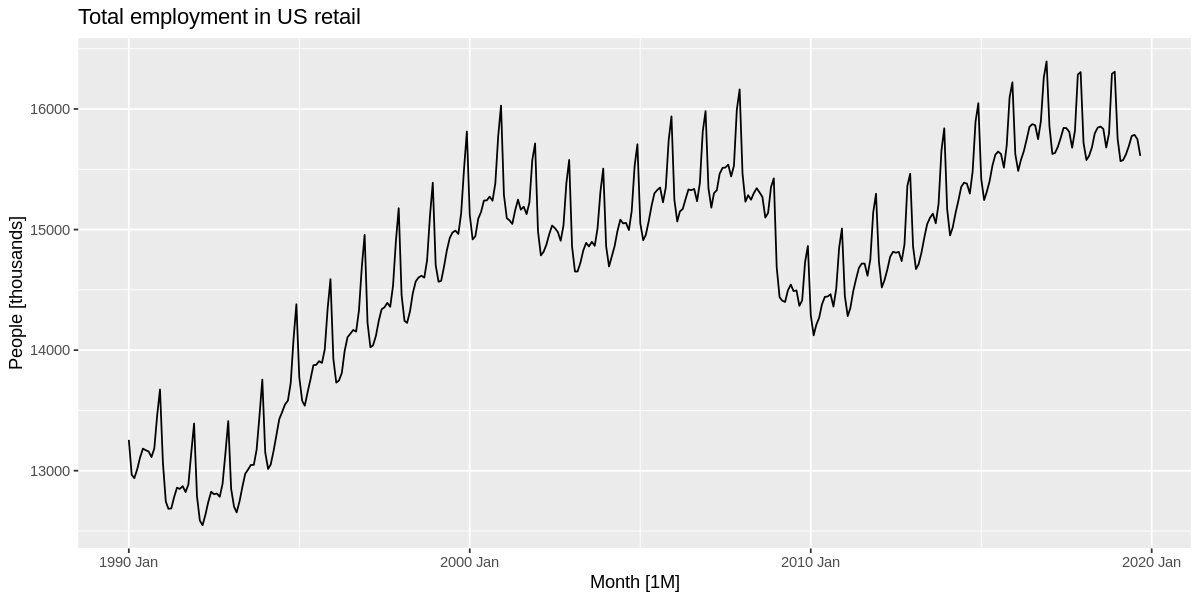

In [5]:
us_retail_employment <- us_employment %>%
    filter(year(Month) >= 1990, Title == "Retail Trade") %>%
    select(-Series_ID)

autoplot(us_retail_employment, Employed) +
    labs(y = "People [thousands]", title = "Total employment in US retail")

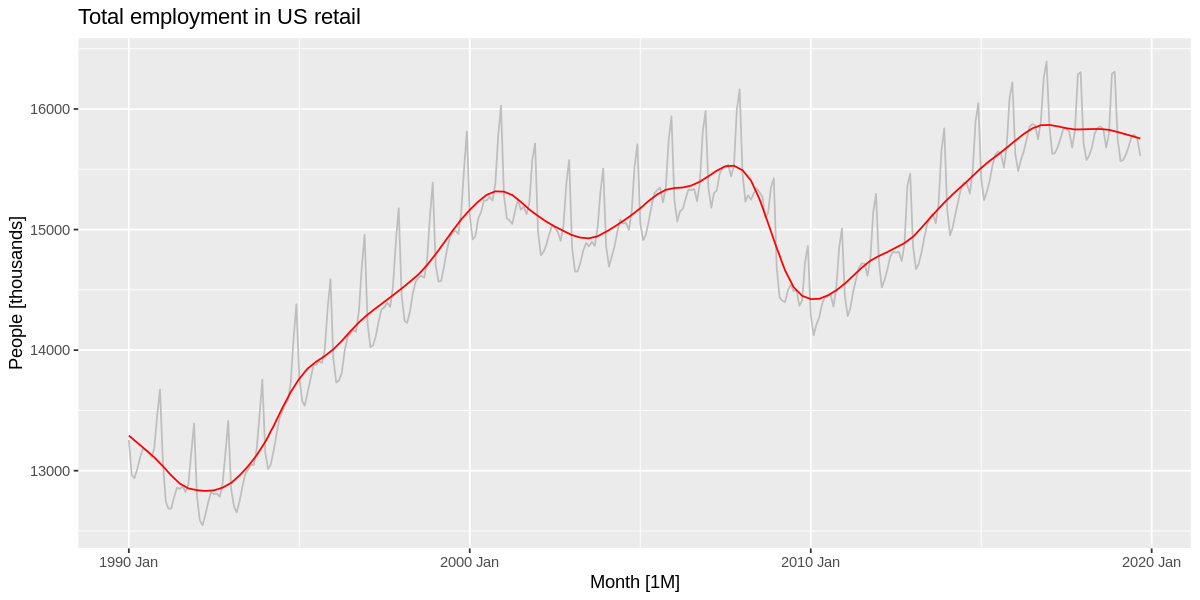

In [6]:
dcmp <- us_retail_employment %>%
    model(STL(Employed))

autoplot(us_retail_employment, Employed, color = "gray") +
    autolayer(components(dcmp), trend, color = "red") +
    labs(y = "People [thousands]", title = "Total employment in US retail")

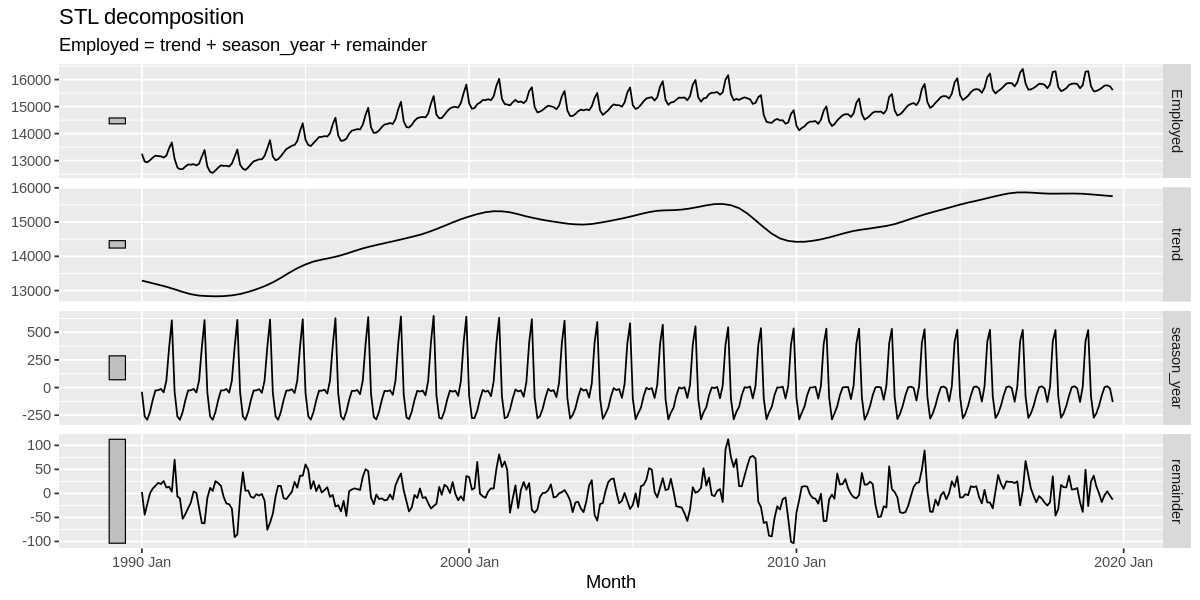

In [7]:
components(dcmp) %>% autoplot

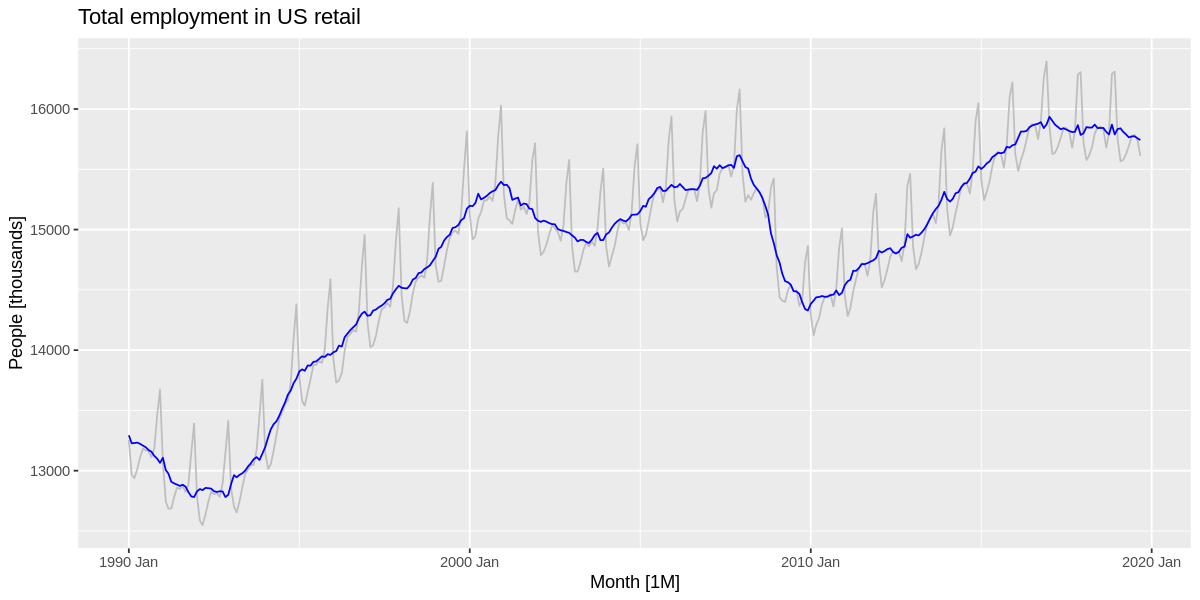

In [8]:
dcmp <- us_retail_employment %>%
    model(STL(Employed))

autoplot(us_retail_employment, Employed, color = "gray") +
    autolayer(components(dcmp), season_adjust, color = "blue") +
    labs(y = "People [thousands]", title = "Total employment in US retail")

Warning message:
“Removed 4 row(s) containing missing values (geom_path).”


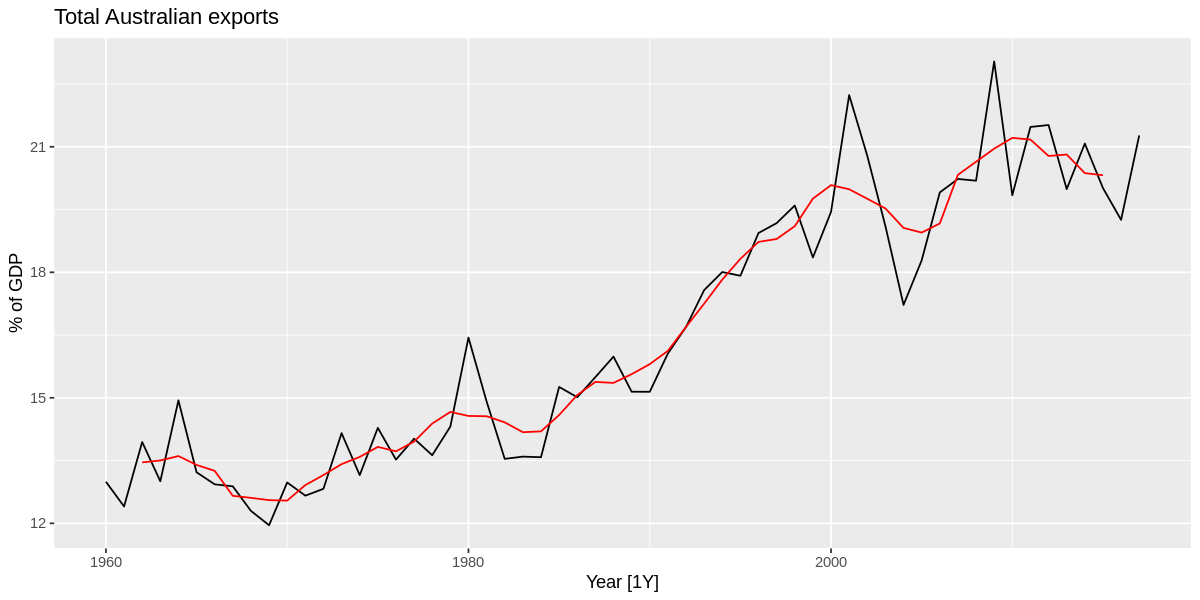

In [11]:
aus_exports <- global_economy %>%
    filter(Code == "AUS") %>%
    mutate(
        `5-MA` = slider::slide_dbl(Exports, mean, .before = 2, .after = 2, .complete = TRUE)
    )

aus_exports %>%
    autoplot(Exports) +
    autolayer(aus_exports, `5-MA`, color = "red") +
    labs(y = "% of GDP", title = "Total Australian exports")

In [17]:
beer <- aus_production %>%
    filter(year(Quarter) >= 1992) %>%
    select(Quarter, Beer)

beer_ma <- beer %>%
    mutate(
        `4-MA` = slider::slide_dbl(Beer, mean, .before = 1, .after = 2, .complete = TRUE),
        `2x4-MA` = slider::slide_dbl(`4-MA`, mean, .before = 1, .after = 0, .complete = TRUE),
    )

Warning message:
“Removed 12 row(s) containing missing values (geom_path).”


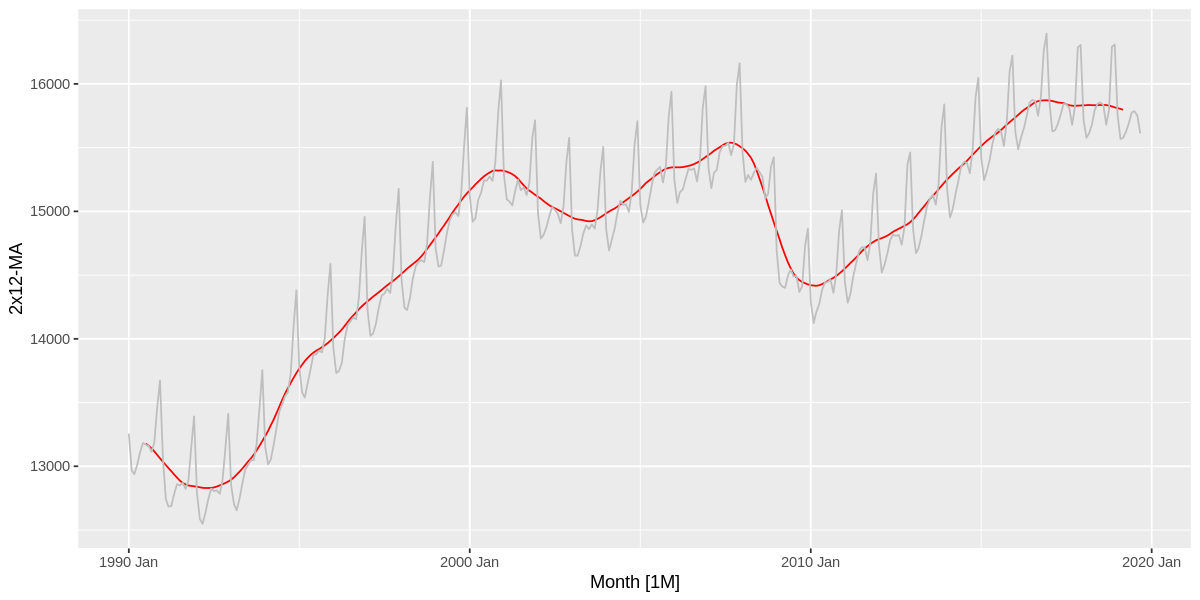

In [19]:
us_retail_employment_ma <- us_retail_employment %>%
    mutate(
        `12-MA` = slider::slide_dbl(Employed, mean, .before = 5, .after = 6, .complete = TRUE),
        `2x12-MA` = slider::slide_dbl(`12-MA`, mean, .before = 1, .after = 0, .complete = TRUE),
    )

autoplot(us_retail_employment_ma, `2x12-MA`, color = 'red') +
    autolayer(us_retail_employment_ma, Employed, color = 'grey')

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”


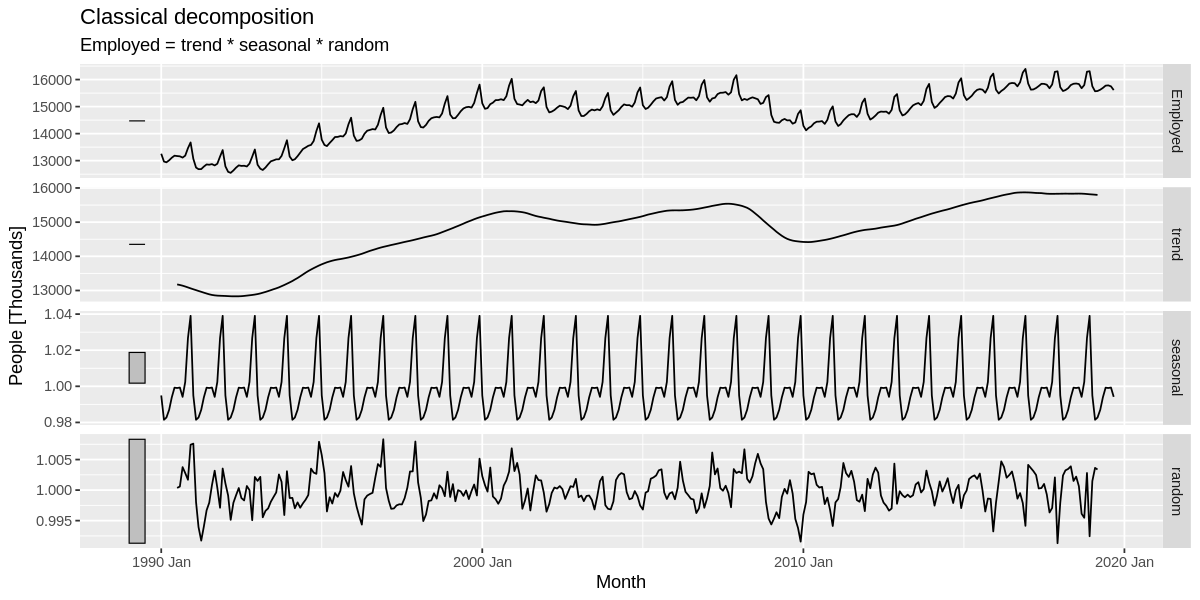

In [23]:
us_retail_employment %>%
    model(
        classical_decomposition(Employed, type = "multiplicative")
    ) %>%
    components() %>%
    autoplot() + 
    labs(y = "People [Thousands]")

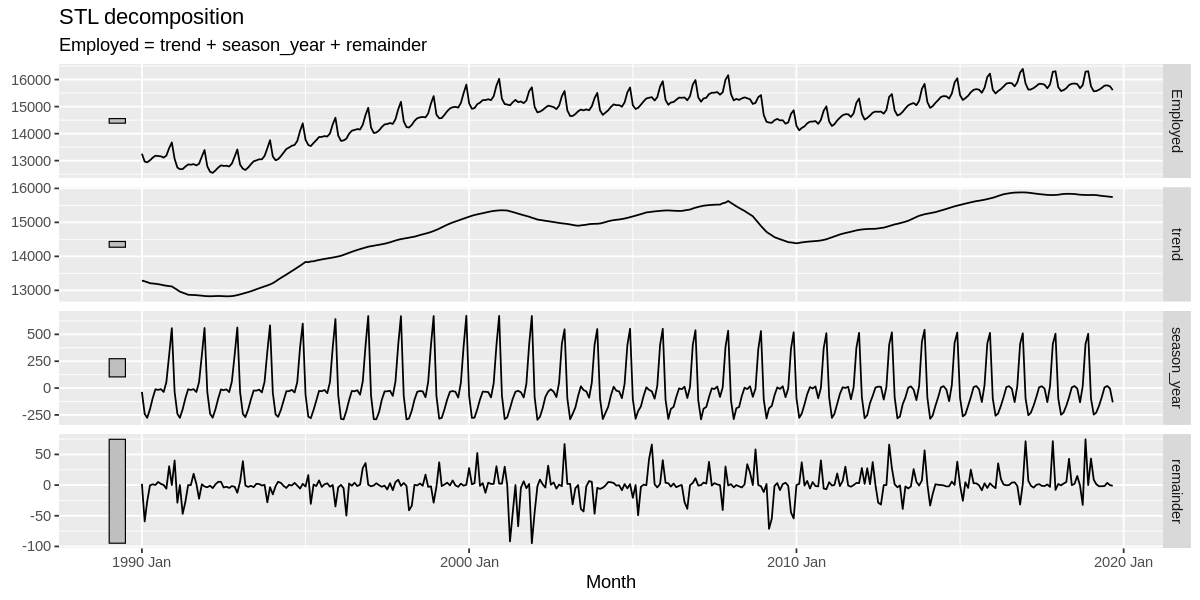

In [29]:
us_retail_employment %>%
    model(
        STL(Employed ~ trend(window = 7) + season(window = 5), robust = TRUE)
    ) %>%
    components() %>%
    autoplot()